# Logistic Regression Assignment 

### Amazon Fine Food Reviews Analysis

**Data Source:** https://www.kaggle.com/snap/amazon-fine-food-reviews


###### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

**Number of reviews:** 568,454<br>
**Number of users:** 256,059<br>
**Number of products:** 74,258<br>
**Timespan:** Oct 1999 - Oct 2012<br>
**Number of Attributes/Columns in data:** 10 <br>

**Attribute Information:**

1.Id<br>
2.ProductId - unique identifier for the product<br>
3.UserId - unqiue identifier for the user <br>
4.ProfileName<br>
5.HelpfulnessNumerator - number of users who found the review helpful<br>
6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not<br>
7.Score - rating between 1 and 5<br>
8.Time - timestamp for the review<br>
9.Summary - brief summary of the review<br>
10.Text - text of the review<br>


## Objective:
- 1. Apply the Logistic Regression algorithm on BOW,TF-IDF,Word2Vec, TF-IDF Word2Vec
- 2. Apply the both GridSearch and RandomSearch cross validation
- 3. Evaluate differnet metrics such as precision ,recall,f1-score and plot the confusion matrix
- 4. Show how sparsity increase as lambda increase or C decreases with L1 regularizer
- 5. Use Pertubation to check for the multicolinerity of features



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer

### Load the pre processing file in sql format

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final_data = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

DatabaseError: Execution failed on sql '
SELECT * FROM Reviews 
': no such table: Reviews

In [3]:
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [4]:
final_data.shape

(364171, 12)

In [5]:
print(type(final_data))

<class 'pandas.core.frame.DataFrame'>


In [6]:
# now make classification label for Score label

def make_0_1(x):
    if x=='positive':
        return 1
    else:
        return 0

In [7]:
final_data['Score']= final_data['Score'].map(make_0_1)

In [8]:
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [10]:
#sampling of 364k data point
n_samples = 100000
final_data_sample = final_data.sample(n_samples)

final_data_sample.sort_values('Time',axis=0,inplace=True)

final_data_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...
325,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...
427,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,b'get crazi realli imposs today find french vh...
242,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...


In [12]:
final_data_sample.shape

(100000, 12)

In [13]:
#Functions to save objects for later use and retireve it
import pickle
def SaveToFile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def OpenFromFile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

### Logistic Regression on BOW for Uni-gram

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = final_data_sample['CleanedText']
y = final_data_sample['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
uni_gram = CountVectorizer()
X_train = uni_gram.fit_transform(X_train)

# normalize the data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)



Train Data Size:  (70000, 32007)
Test Data Size:  (30000, 32007)


### Find the best C value

In [15]:
lr = LogisticRegression()

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1) 
# https://stackoverflow.com/questions/19018333/gridsearchcv-on-logisticregression-in-scikit-learn
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-Uni-Gram")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.5min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 91.46%


In [16]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [17]:
print(gscv.best_index_ )

9


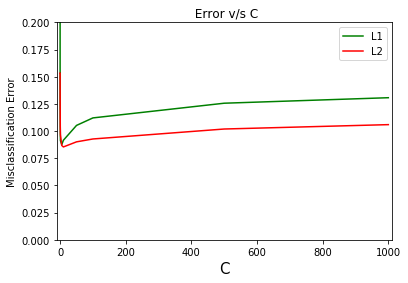

In [18]:
# plotting of L1 and L2 error
def error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title(' Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gscv = OpenFromFile("LR-Uni-Gram")
error_vs_c(gscv)

Accuracy on test set: 91.453%
Precision on test set: 0.930
Recall on test set: 0.969
F1-Score on test set: 0.949
Non Zero weights: 32007


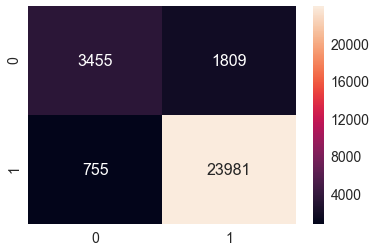

In [19]:
# testing accuracy on the best_estimator
lr = LogisticRegression(C=10,penalty='l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [20]:
### Show how sparsity increase as if we increase the value of C
C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
def sparsity_increase(i,j):
    lr = LogisticRegression(C=i,penalty=j)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print("C_value and l1_value=",i,j)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(lr.coef_))
    print("-"*100)


for i,j in zip(C_value,l1_value):
    sparsity_increase(i,j)
    
    

C_value and l1_value= 1000 l1
Accuracy on test set: 86.417%
Non Zero weights: 13812
----------------------------------------------------------------------------------------------------
C_value and l1_value= 100 l1
Accuracy on test set: 88.797%
Non Zero weights: 10915
----------------------------------------------------------------------------------------------------
C_value and l1_value= 10 l1
Accuracy on test set: 91.003%
Non Zero weights: 5430
----------------------------------------------------------------------------------------------------
C_value and l1_value= 1 l1
Accuracy on test set: 91.050%
Non Zero weights: 1100
----------------------------------------------------------------------------------------------------
C_value and l1_value= 0.1 l1
Accuracy on test set: 88.280%
Non Zero weights: 199
----------------------------------------------------------------------------------------------------
C_value and l1_value= 0.01 l1
Accuracy on test set: 82.473%
Non Zero weights: 14
-----

Here we see that how C values increase the sparsity of matrix increases. At C_value = 0.0001 and l1 regularizer we get 0 non zero weights. That menas that we dont have any non zero value

### Logistic Regression using RandomSearch cross validation for uni-gram 

In [21]:
lr = LogisticRegression()

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1) 
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR_RandomSearch-Uni-Gram")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 91.46%


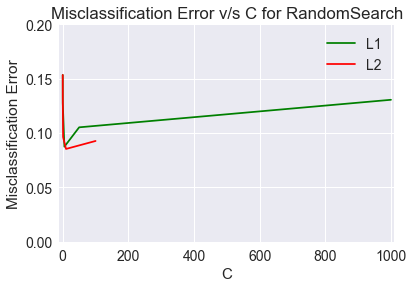

In [22]:
#Function to plot Misclassification error against C
def error_vs_c(gscv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gscv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C for RandomSearch')
    plt.plot(x1[ind1],y1[ind1],'g',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
gscv = OpenFromFile("LR_RandomSearch-Uni-Gram")
error_vs_c(gscv)

In [23]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy on test set: 91.453%
Precision on test set: 0.930
Recall on test set: 0.969
F1-Score on test set: 0.949
Non Zero weights: 32007


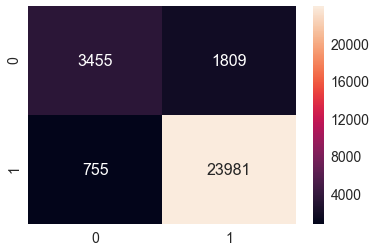

In [24]:
# test on best C value and penality l2 with random search 
# testing accuracy on the best_estimator
lr = LogisticRegression(C=10,penalty='l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Perturbation Test

In [25]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 91.453%
Non Zero weights: 32007


In [26]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 2.96212579e-01  9.57535270e-04  2.42380144e-02  1.58068050e-02
  1.58068050e-02  3.29885095e-02  4.80637912e-02  3.56007373e-02
  6.77553534e-02  3.95865703e-03  5.06581547e-02  3.40974155e-02
  2.62866285e-02 -4.82073684e-01  1.44194742e-03  1.90194527e-03
  9.41929903e-02  6.82898639e-02  4.53883755e-03  2.82408275e-02
  6.72783824e-02  3.31224775e-01  7.53202088e-02  1.22980124e-01
 -1.01862563e+00  3.89753643e-04  2.45664893e-01 -1.70724627e+00
  2.16257201e-03 -5.93525367e-01  1.73812146e-01 -1.17752736e-01
  2.54015244e-02  6.34881227e-03  2.25092342e-02 -6.68859709e-01
  3.07299280e-02  1.99124992e-01 -1.10714917e+00  8.32286618e-05
  1.92323294e-01  1.52568028e-03  1.07536582e-02  3.24279278e-01
 -5.67856854e-02  3.32666312e-02  1.87183007e-01  1.84378073e-01
  1.62566649e-01  1.40525845e+00]


In [27]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [28]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 91.450%
Non Zero weights: 32007


In [29]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 2.95685775e-01  9.62550865e-04  2.43332606e-02  1.58727716e-02
  1.57977882e-02  3.31158324e-02  4.82320560e-02  3.60225834e-02
  6.68331551e-02  4.07966401e-03  5.03680439e-02  3.42918480e-02
  2.64442737e-02 -4.81968283e-01  1.45629582e-03  1.91288014e-03
  9.33173721e-02  6.78954542e-02  4.54684464e-03  2.82294647e-02
  6.72869697e-02  3.29823632e-01  7.52806314e-02  1.23414236e-01
 -1.01380553e+00  3.91831683e-04  2.45359906e-01 -1.70880504e+00
  2.17402384e-03 -5.91883790e-01  1.72680108e-01 -1.18037812e-01
  2.52987793e-02  6.31834046e-03  2.30326004e-02 -6.71269741e-01
  3.07022740e-02  1.98145135e-01 -1.10761479e+00  8.54898638e-05
  1.92227640e-01  1.52992326e-03  1.08248089e-02  3.22494551e-01
 -5.71331990e-02  3.34091629e-02  1.86688546e-01  1.85963562e-01
  1.61492828e-01  1.40558436e+00]


In [30]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [31]:
print(weights_diff[np.where(weights_diff > 30)].size)

25


In [32]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-14.8991	worst          				9.0632	fantast        
	-10.5450	horribl        				8.9773	skeptic        
	-10.3726	aw             				8.9537	delici         
	-10.2630	yuck           				8.8822	perfect        
	-9.7691	terribl        				8.5154	yummi          
	-9.4868	concept        				8.4581	excel          
	-9.3755	disappoint     				8.2495	awesom         
	-9.3582	threw          				7.7924	best           
	-9.2626	gross          				7.7755	amaz           
	-8.8382	return         				7.7155	worri          
	-8.8071	bland          				7.4583	beat           
	-8.7702	undrink        				7.4573	great          
	-8.7697	unpleas        				7.4441	yum            
	-8.3746	disgust        				7.3042	afford         
	-8.3418	useless        				7.3026	satisfi        
	-8.3393	sorri          				7.1397	terrif         
	-8.1469	ined           				7.1161	addict         
	-8.02

### Logistic Regression GridSearch for Bi-garm

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
bi_gram = CountVectorizer(ngram_range=(1,2))
X_train = bi_gram.fit_transform(X_train)

# normalize the data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 981369)
Test Data Size:  (30000, 981369)


In [107]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-GridSearch-Bi-gram")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 17.7min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 91.96%


In [108]:
print(gscv.best_estimator_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [109]:
print(gscv.best_index_)

1


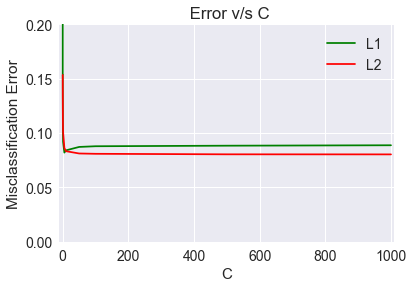

In [110]:
# plotting of L1 and L2 error
def error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title(' Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gscv = OpenFromFile("LR-GridSearch-Bi-gram")
error_vs_c(gscv)

Accuracy on test set: 92.443%
Precision on test set: 0.939
Recall on test set: 0.972
F1-Score on test set: 0.955
Non Zero weights: 981369


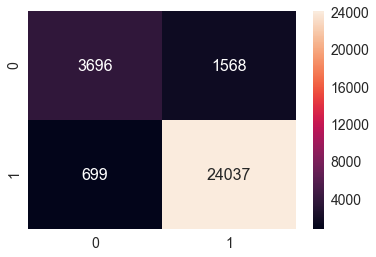

In [111]:
# testing accuracy on the best_estimator
lr = LogisticRegression(C=1000,penalty='l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Show how sparsity increase as lambda increase (c=1/lambda)

In [112]:
### Show how sparsity increase as if we increase the value of C
C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
def sparsity_increase(i,j):
    lr = LogisticRegression(C=i,penalty=j)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print("C_value is: {} and l1_value is: {}".format(i,j))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(lr.coef_))
    print("-"*100)


for i,j in zip(C_value,l1_value):
    sparsity_increase(i,j)

C_value is: 1000 and l1_value is: l1
Accuracy on test set: 91.510%
Non Zero weights: 16724
----------------------------------------------------------------------------------------------------
C_value is: 100 and l1_value is: l1
Accuracy on test set: 91.380%
Non Zero weights: 13024
----------------------------------------------------------------------------------------------------
C_value is: 10 and l1_value is: l1
Accuracy on test set: 91.967%
Non Zero weights: 8712
----------------------------------------------------------------------------------------------------
C_value is: 1 and l1_value is: l1
Accuracy on test set: 91.450%
Non Zero weights: 1034
----------------------------------------------------------------------------------------------------
C_value is: 0.1 and l1_value is: l1
Accuracy on test set: 87.740%
Non Zero weights: 167
----------------------------------------------------------------------------------------------------
C_value is: 0.01 and l1_value is: l1
Accuracy on te

We see that how sparsity increases as lambda increases or C value decreases. At C value 1000, numbers of non zeros weight was 16775 and at C value 0.0001 , numbers of non zeros weight is 0

### Logistic Regression Random Search for Bi-garm

In [113]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-RandomSearch-Bi-gram")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 91.67%


In [114]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [115]:
print(gscv.best_index_)

0


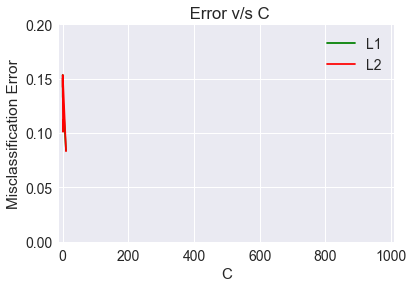

In [116]:
# plotting of L1 and L2 error
gscv = OpenFromFile("LR-RandomSearch-Bi-gram")
error_vs_c(gscv)

Accuracy on test set: 92.140%
Precision on test set: 0.933
Recall on test set: 0.975
F1-Score on test set: 0.953
Non Zero weights: 981369


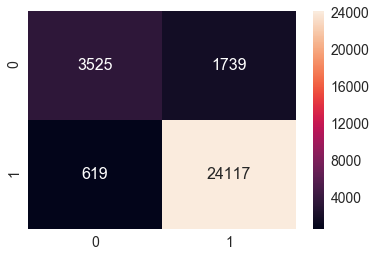

In [117]:
# testing accuracy on the best_estimator
lr = LogisticRegression(C=10,penalty='l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Perturbation Test

In [118]:
lr = LogisticRegression(C= 500, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 92.430%
Non Zero weights: 981369


In [119]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 5.11036748e-01  7.55569801e-03  5.03481050e-01  2.72875646e-04
  8.34972367e-03  8.34972367e-03  1.99039216e-02  1.99039216e-02
  1.99039216e-02  1.99039216e-02  6.22769967e-02  6.22769967e-02
  9.06248720e-03  9.06248720e-03  1.23034164e-01  1.23034164e-01
  9.72156012e-02  9.72156012e-02  2.54955872e-03  2.54955872e-03
  2.20643217e-02  2.20643217e-02  2.18189192e-01  2.18189192e-01
  3.28712877e-02  3.28712877e-02 -4.75639548e-01 -4.75639548e-01
  3.83171074e-04  3.83171074e-04  1.48276476e-03  4.58025119e-02
  2.91288060e-02  1.34251756e-02  3.24853026e-03  7.13400063e-01
  7.13400063e-01  7.50330850e-03  7.50330850e-03  2.17871001e-02
  2.17871001e-02  1.03263097e-01  1.03263097e-01  6.22169799e-01
  6.22169799e-01  3.44535060e-01  3.44535060e-01  5.34307414e-01
  5.34307414e-01 -1.02821554e+00]


In [120]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [121]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 92.153%
Non Zero weights: 981369


In [122]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 0.18805666  0.00635642  0.18147036  0.00051698  0.01407884  0.01407897
  0.00726661  0.00724006  0.00726623  0.00724382  0.02583405  0.02584154
  0.01370867  0.01369844  0.04445319  0.04438057  0.02896293  0.02897035
  0.00435272  0.00434892  0.01555251  0.01553862  0.05425905  0.05421807
  0.02324474  0.02321948 -0.14760349 -0.14778084  0.000785    0.00078484
  0.0026047   0.04039721  0.02407073  0.01241171  0.00388742  0.1039134
  0.10391917  0.0060061   0.00599994  0.02040731  0.02041769  0.0422133
  0.0421522   0.15970133  0.15986977  0.08787805  0.08780849  0.11639891
  0.11615973 -0.35095218]


In [123]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [124]:
print(weights_diff[np.where(weights_diff > 30)].size)

619327


Features have multi-collinearity

In [125]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-15.1724	worst          				13.2376	high recommend 
	-12.4820	disappoint     				11.3251	delici         
	-11.7876	horribl        				10.8352	perfect        
	-11.6279	terribl        				9.6624	excel          
	-11.4562	aw             				9.6360	best           
	-10.8600	return         				9.4581	fantast        
	-10.5031	bland          				9.3994	yummi          
	-9.7729	threw          				9.0435	great          
	-9.5063	yuck           				8.9052	awesom         
	-9.3534	stale          				8.8913	wont disappoint
	-9.3103	sorri          				8.8281	amaz           
	-9.2795	gross          				8.3622	well worth     
	-9.1056	disgust        				7.9449	satisfi        
	-9.0771	weak           				7.8004	skeptic        
	-8.5887	unfortun       				7.4586	tasti          
	-8.5614	unpleas        				7.4274	thank          
	-8.4335	wont buy       				7.3742	favorit        


### Logistic Regression TF-IDF 
#### GridSearch

In [127]:
X = final_data_sample['CleanedText']
y = final_data_sample['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 981369)
Test Data Size:  (30000, 981369)


In [128]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-GridSearch-TF-IDF")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.4min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 91.79%


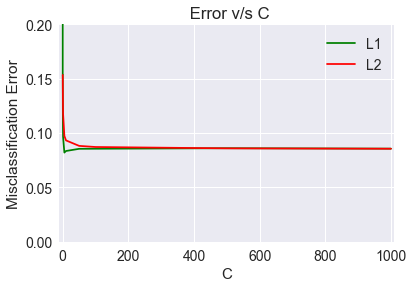

In [129]:
gscv = OpenFromFile("LR-GridSearch-TF-IDF")
error_vs_c(gscv)

In [131]:
print(gscv.best_estimator_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [132]:
print(gscv.best_index_)

10


Accuracy on test set: 92.140%
Precision on test set: 0.939
Recall on test set: 0.967
F1-Score on test set: 0.953
Non Zero weights: 6477


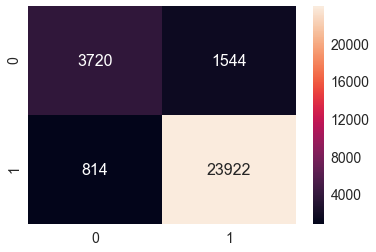

In [134]:
lr = LogisticRegression(C= 5, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Show how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [135]:
### Show how sparsity increase as if we increase the value of C
C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
def sparsity_increase(i,j):
    lr = LogisticRegression(C=i,penalty=j)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print("C_value is: {} and l1_value is: {}".format(i,j))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Non Zero weights:",np.count_nonzero(lr.coef_))
    print("-"*100)


for i,j in zip(C_value,l1_value):
    sparsity_increase(i,j)

C_value is: 1000 and l1_value is: l1
Accuracy on test set: 91.787%
Non Zero weights: 19779
----------------------------------------------------------------------------------------------------
C_value is: 100 and l1_value is: l1
Accuracy on test set: 91.563%
Non Zero weights: 14506
----------------------------------------------------------------------------------------------------
C_value is: 10 and l1_value is: l1
Accuracy on test set: 91.980%
Non Zero weights: 10168
----------------------------------------------------------------------------------------------------
C_value is: 1 and l1_value is: l1
Accuracy on test set: 91.370%
Non Zero weights: 945
----------------------------------------------------------------------------------------------------
C_value is: 0.1 and l1_value is: l1
Accuracy on test set: 86.507%
Non Zero weights: 101
----------------------------------------------------------------------------------------------------
C_value is: 0.01 and l1_value is: l1
Accuracy on te

As we see that @ C value is 1000 and numbers of non zeros weight is 19779 and @C value is 0.0001 and numbers of non zero weight is 0

#### Random Search

In [137]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-RandomSearch-TF_IDF")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1000}
Best Accuracy: 91.42%


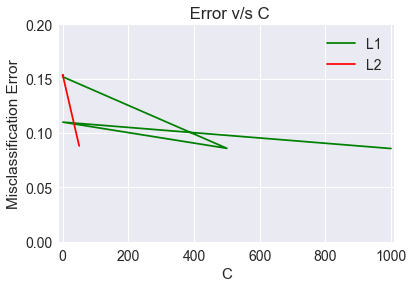

In [139]:
gscv = OpenFromFile("LR-RandomSearch-TF_IDF")
error_vs_c(gscv)

Accuracy on test set: 92.137%
Precision on test set: 0.939
Recall on test set: 0.967
F1-Score on test set: 0.953
Non Zero weights: 6475


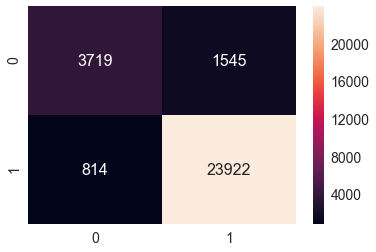

In [140]:
#Testing Accuracy on Test data

lr = LogisticRegression(C= 5, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Perturbation Test

In [141]:
lr = LogisticRegression(C= 500, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 92.440%
Non Zero weights: 981369


In [143]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 0.53486728  0.02340378  0.53107616  0.0042988   0.05965686  0.05965686
  0.02568999  0.02568999  0.02568999  0.02568999  0.08785486  0.08785486
  0.06020582  0.06020582  0.15687535  0.15687535  0.13368848  0.13368848
  0.01856511  0.01856511  0.05115154  0.05115154  0.2155314   0.2155314
  0.08561019  0.08561019 -0.52690557 -0.52690557  0.00365806  0.00365806
  0.01205914  0.11226466  0.05345168  0.05326936  0.01276888  0.43066759
  0.43066759  0.0192508   0.0192508   0.05278068  0.05278068  0.14589192
  0.14589192  0.53564945  0.53564945  0.38315871  0.38315871  0.41078827
  0.41078827 -1.0349017 ]


In [144]:
print(weights1[weights1<=0.0001])

[-0.52690557 -0.52690557 -1.0349017  ... -0.0425448  -0.2192959
 -0.2192959 ]


In [145]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [146]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 92.143%
Non Zero weights: 981369


In [147]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 0.2050128   0.01596972  0.19669839  0.00156978  0.03864591  0.03863218
  0.01175323  0.0117591   0.01172295  0.01174183  0.03789038  0.03789981
  0.03595117  0.03596792  0.05853326  0.05847618  0.04850828  0.04850634
  0.01170702  0.01170548  0.02666991  0.02670707  0.08010733  0.08008843
  0.04217526  0.04221496 -0.19253414 -0.19254626  0.00224388  0.00224603
  0.00847719  0.06202143  0.02883859  0.02930408  0.00791387  0.10383394
  0.10378071  0.01079695  0.01081118  0.03308313  0.0331062   0.0588015
  0.05877098  0.1693144   0.16949776  0.12704444  0.12704722  0.11236033
  0.1123204  -0.40177356]


In [148]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [149]:
print(weights_diff[np.where(weights_diff > 30)].size)

749139


749139 feature have changes and greater than 30% ,So it have muti-collineraity

In [150]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,lr)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-19.2317	disappoint     				22.0388	great          
	-15.7572	worst          				17.9332	best           
	-13.4390	return         				17.7837	love           
	-12.9311	horribl        				17.1819	delici         
	-12.7544	terribl        				15.5350	perfect        
	-12.4552	aw             				12.9845	excel          
	-11.1761	bland          				12.7804	high recommend 
	-10.6048	stale          				11.4473	favorit        
	-10.3112	threw          				11.0721	nice           
	-10.1296	unfortun       				10.8774	good           
	-9.8717	weak           				10.2717	tasti          
	-9.7072	sorri          				10.1976	amaz           
	-9.1905	disgust        				10.1400	thank          
	-9.0719	gross          				9.8208	wonder         
	-9.0535	yuck           				9.7206	yummi          
	-8.8522	wast           				9.4254	awesom         
	-8.7016	bad            				9.3304	enj

### Logistic Regression Word2Vec

In [154]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [155]:
#filtering sentence
final_string=[]
s=''
for sentence in final_data_sample['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)

In [156]:
final_data_sample['Cleaned_text']=final_string

In [159]:
import gensim

#getting the list of sentences in a 'list'
i=0
list_of_sentences=[]
for sent in final_data_sample['Cleaned_text'].values:
    filtered_sentence=[]    
    for w in sent.split():
        w=w.decode("utf-8") 
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [160]:
len(list_of_sentences)

100000

In [161]:
#defining a word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)    
words=list(w2v_model.wv.vocab)
print(len(words))

11110


In [162]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(50)
    count_vec=0;
    for word in sentence:
        try:
            vec=w2v_model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [163]:
np.argwhere(np.isnan(vectors)) 

array([[ 1232,     0],
       [ 1232,     1],
       [ 1232,     2],
       [ 1232,     3],
       [ 1232,     4],
       [ 1232,     5],
       [ 1232,     6],
       [ 1232,     7],
       [ 1232,     8],
       [ 1232,     9],
       [ 1232,    10],
       [ 1232,    11],
       [ 1232,    12],
       [ 1232,    13],
       [ 1232,    14],
       [ 1232,    15],
       [ 1232,    16],
       [ 1232,    17],
       [ 1232,    18],
       [ 1232,    19],
       [ 1232,    20],
       [ 1232,    21],
       [ 1232,    22],
       [ 1232,    23],
       [ 1232,    24],
       [ 1232,    25],
       [ 1232,    26],
       [ 1232,    27],
       [ 1232,    28],
       [ 1232,    29],
       [ 1232,    30],
       [ 1232,    31],
       [ 1232,    32],
       [ 1232,    33],
       [ 1232,    34],
       [ 1232,    35],
       [ 1232,    36],
       [ 1232,    37],
       [ 1232,    38],
       [ 1232,    39],
       [ 1232,    40],
       [ 1232,    41],
       [ 1232,    42],
       [ 12

In [164]:
z= [1232,16511,33428,52957,80147,85013,97919]

In [165]:
#detected a row containing nan value, deleting it
vectors=np.delete(vectors,z , axis=0)

In [166]:
np.argwhere(np.isnan(vectors))

array([], shape=(0, 2), dtype=int64)

In [167]:
sample_score = final_data_sample['Score']

In [168]:
sample_score=np.array(sample_score)

In [169]:
sample_score=np.delete(sample_score,z,axis=0)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(vectors,sample_score,test_size=0.3,shuffle=False)

In [172]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-Word2Vec")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 12.6min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 88.24%


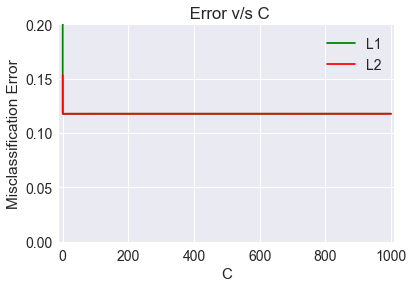

In [173]:
gscv = OpenFromFile("LR-Word2Vec")
error_vs_c(gscv)

In [174]:
print(gscv.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [175]:
print(gscv.best_index_)

12


Accuracy on test set: 87.422%
Precision on test set: 0.890
Recall on test set: 0.967
F1-Score on test set: 0.927
Non Zero weights: 50


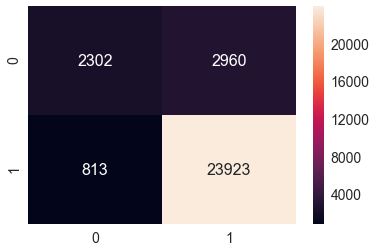

In [176]:
#Testing Accuracy on Test data with best hyper parametrs
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C= 1, penalty= 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Random Search Word2Vec

In [177]:
lr = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR-RandomSearch-Word2Vec")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 1}
Best Accuracy: 88.23%


In [178]:
print(gscv.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [179]:
print(gscv.best_index_)

2


Accuracy on test set: 87.399%
Precision on test set: 0.890
Recall on test set: 0.967
F1-Score on test set: 0.927
Non Zero weights: 50


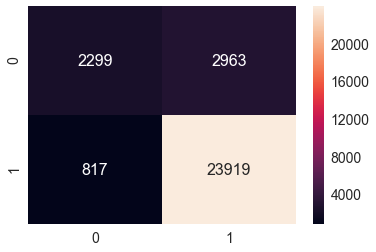

In [180]:
#Testing Accuracy on Test data with best hyper parametrs
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C= 1, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

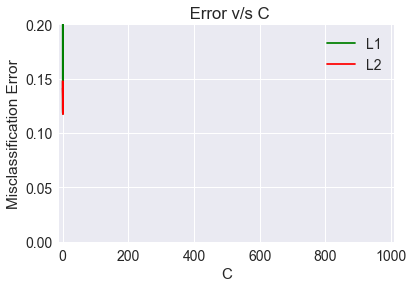

In [181]:
gscv = OpenFromFile("LR-RandomSearch-Word2Vec")
error_vs_c(gscv)

### Perturbation Test

In [185]:
lr = LogisticRegression(C= 100, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 87.382%
Non Zero weights: 50


In [186]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 1.11481534 -0.61690144  0.46383862 -1.08833839 -0.64730038 -1.06272744
 -0.37572612 -0.91735724  0.26684892 -1.51230283 -0.01510711  0.42048897
  0.66287556 -0.96607495 -0.71367551  0.22188898  0.04822971  0.17254096
  0.23189781  0.42207446 -0.61587118  0.02085823  0.23078247 -1.18628109
 -0.47482806  1.04977856 -1.15704838 -0.41295597 -1.32630265 -0.61311304
 -0.48050484  0.6070716   0.59927513  0.39739629  0.4654252   0.31171651
  0.25188537  0.07821047  0.26635899  0.80996929  0.08038552 -0.02529015
 -0.10621743  0.08412767  1.0004308  -0.12545233  1.60543559  0.31394309
 -0.31150545 -0.05617348]


In [187]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [188]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 87.392%
Non Zero weights: 50


In [189]:

weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 1.11297359 -0.61770077  0.4642501  -1.09122777 -0.64584532 -1.06227639
 -0.37295108 -0.91616281  0.26356474 -1.51011802 -0.01575377  0.41801233
  0.66179685 -0.96343481 -0.71299939  0.2213586   0.04746063  0.17056578
  0.22915415  0.42284422 -0.6172101   0.01873532  0.23300476 -1.18523984
 -0.4745159   1.0483166  -1.15496152 -0.41288786 -1.32742613 -0.60918387
 -0.47814764  0.60611839  0.60158295  0.39745559  0.46631876  0.31164754
  0.25057176  0.07957782  0.26428178  0.80732286  0.0780135  -0.02661947
 -0.10970906  0.08437677  0.99919105 -0.12535335  1.60422519  0.31230585
 -0.31176268 -0.060089  ]


In [192]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [193]:
print(weights_diff[np.where(weights_diff > 30)].size)

0


### Logistic Regression TF-IDF Word2Vec
#### GridSearch

In [230]:
# sampling of 25k data points for tfidf word2vec
df_sample_25k = final_data_sample.sample(n=25000)


In [233]:
#filtering sentence
final_string=[]
s=''
for sentence in df_sample_25k['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)

In [225]:
df_sample_25k.shape

(5000, 13)

In [234]:
df_sample_25k['Cleaned_text']=final_string

In [235]:
import gensim

#getting the list of sentences in a 'list'
i=0
list_of_sentences=[]
for sent in df_sample_25k['Cleaned_text'].values:
    filtered_sentence=[]    
    for w in sent.split():
        w=w.decode("utf-8") 
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [236]:
len(list_of_sentences)

25000

In [237]:
#defining a word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)    
words=list(w2v_model.wv.vocab)
print(len(words))

6070


In [238]:
#defining a word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)    
words=list(w2v_model.wv.vocab)
print(len(words))

6070


In [239]:
sample_score = df_sample_25k['Score']


In [240]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(df_sample_25k['Cleaned_text'].values)

In [241]:
#defining a word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50, workers=4)    
words=list(w2v_model.wv.vocab)
print(len(words))

6070


In [242]:
features=tf_idf_vect.get_feature_names()
len(features)

17493

In [243]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [244]:
z=np.argwhere(np.isnan(tfidf_vectors))[:,0]

In [245]:
z=list(set(z))

In [246]:
np.argwhere(np.isnan(tfidf_vectors)) 

array([[ 3646,     0],
       [ 3646,     1],
       [ 3646,     2],
       [ 3646,     3],
       [ 3646,     4],
       [ 3646,     5],
       [ 3646,     6],
       [ 3646,     7],
       [ 3646,     8],
       [ 3646,     9],
       [ 3646,    10],
       [ 3646,    11],
       [ 3646,    12],
       [ 3646,    13],
       [ 3646,    14],
       [ 3646,    15],
       [ 3646,    16],
       [ 3646,    17],
       [ 3646,    18],
       [ 3646,    19],
       [ 3646,    20],
       [ 3646,    21],
       [ 3646,    22],
       [ 3646,    23],
       [ 3646,    24],
       [ 3646,    25],
       [ 3646,    26],
       [ 3646,    27],
       [ 3646,    28],
       [ 3646,    29],
       [ 3646,    30],
       [ 3646,    31],
       [ 3646,    32],
       [ 3646,    33],
       [ 3646,    34],
       [ 3646,    35],
       [ 3646,    36],
       [ 3646,    37],
       [ 3646,    38],
       [ 3646,    39],
       [ 3646,    40],
       [ 3646,    41],
       [ 3646,    42],
       [ 36

In [247]:
z = [3646,9966,17590]

In [248]:
tfidf_vectors=np.delete(tfidf_vectors,z , axis=0)

In [252]:
sample_score=np.array(sample_score)

In [253]:
sample_score=np.delete(sample_score,z,axis=0)

In [254]:
np.argwhere(np.isnan(tfidf_vectors))

array([], shape=(0, 2), dtype=int64)

In [255]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_vectors,sample_score,test_size=0.3,random_state=0)

In [256]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = GridSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR GridSearch TF_IDF-WORD2VEC")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.5min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 86.05%


In [257]:
print(gscv.best_estimator_)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [258]:
print(gscv.best_index_)

9


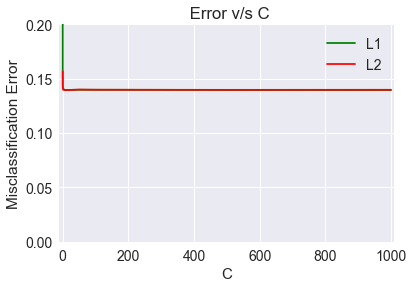

In [260]:
gscv = OpenFromFile("LR GridSearch TF_IDF-WORD2VEC")
error_vs_c(gscv)

Accuracy on test set: 86.187%
Precision on test set: 0.881
Recall on test set: 0.966
F1-Score on test set: 0.922
Non Zero weights: 50


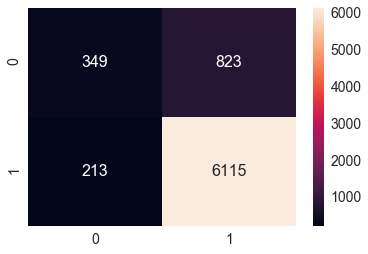

In [259]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [261]:
lr = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1)
gscv.fit(X_train,y_train)
SaveToFile(gscv,"LR RandomSearch TF_IDF-WORD2VEC")
print("Best HyperParameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   46.3s finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 86.03%


In [262]:
print(gscv.best_estimator_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [263]:
print(gscv.best_index_)

7


In [264]:
print(gscv.best_params_)

{'penalty': 'l2', 'C': 5}


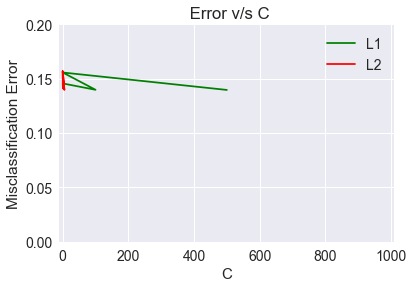

In [265]:
gscv = OpenFromFile("LR RandomSearch TF_IDF-WORD2VEC")
error_vs_c(gscv)

Accuracy on test set: 86.227%
Precision on test set: 0.882
Recall on test set: 0.967
F1-Score on test set: 0.922
Non Zero weights: 50


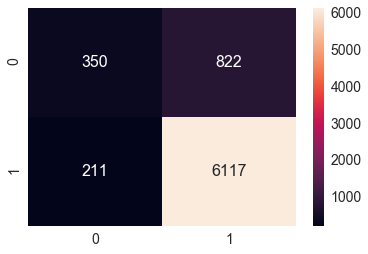

In [266]:
lr = LogisticRegression(C= 5, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Perturbation Test

In [267]:
lr = LogisticRegression(C= 5, penalty= 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 86.227%
Non Zero weights: 50


In [269]:
weights1 = find(lr.coef_[0])[2]
print(weights1[:50])

[ 0.85140106  0.15080667 -0.47137982 -1.21143312 -3.11978205  0.56073579
 -0.8650186  -1.14570778 -1.0323636  -3.55991453 -2.09913239  1.25245376
  0.94425961 -1.15782519 -1.00034488  1.43957025  0.41266888  0.81933431
  0.21314273 -1.52419259 -1.37361027 -0.61091171  0.2468288  -2.46576794
 -1.08290379  1.83429092  0.46649614  0.84639756 -1.91933502  0.99213123
  1.28953694  1.46354464  3.04039226 -1.03135897 -0.17611336  0.89710798
 -2.49996165  1.0640258  -1.37623543 -0.96134839  0.37146899 -0.21674355
  0.1001195   1.1453636   1.96119408 -2.75538027  1.01289341  0.46946743
  0.05331577  1.60813202]


In [270]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [271]:
lr = LogisticRegression(C= 10, penalty= 'l2')
lr.fit(X_train_t,y_train)
y_pred = lr.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Accuracy on test set: 86.187%
Non Zero weights: 50


In [273]:
weights2 = find(lr.coef_[0])[2]
print(weights2[:50])

[ 0.8854831   0.20954222 -0.48808018 -1.23295865 -3.31534742  0.7838621
 -0.98560784 -1.21649871 -1.11355162 -3.6731995  -2.18194766  1.43989541
  0.91836576 -1.1939747  -1.00691925  1.61533207  0.44502648  0.80041981
  0.15059129 -1.7242415  -1.37110227 -0.71027869  0.28379196 -2.54869032
 -1.22970968  2.00331089  0.56482196  0.89470628 -1.95247216  1.08116929
  1.45711025  1.50285721  3.13965845 -1.14557747 -0.16926538  0.97608088
 -2.67150879  1.14837979 -1.36926686 -1.08388821  0.30489863 -0.20058412
  0.0184552   1.28032828  2.10506481 -2.90872486  0.9619239   0.47855119
  0.0053451   1.72583969]


In [274]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100

In [276]:
 print(weights_diff[np.where(weights_diff > 30)].size)

4


### Analysis of Logistic Regression Model on 100k data points

| Feature | Algoritms      | Accuracy | Precision | Recall|F1- Scores |Best Value for C| Penalty    |
| ------- | ---------      | -------- | --------- | ------|-----------|--------------- |------------|
| Uni-gram| GridSearchCV   | 91.45    | 0.93      | 0.96  |0.94       |  C=10          | penalty='l2'|
| Uni-gram| RandomSearchCV | 91.45    | 0.93      | 0.96  |0.94       |  C=10          | penalty='l2'|
|Bi-gram  | GridSearchCV   | 92.44    | 0.93      | 0.97  |0.95       |  C=1000        | penalty='l2'|
|Bi -gram |RandomSearchCV  | 92.14    | 0.93      | 0.97  |0.95       |  C=10          | penalty='l2'|
|TF-IDF   |GridSearchCV    |92.14     | 0.93      | 0.96  |0.95       |  C=5           | penalty='l1'|
|TF-IDF   |RandomSearchCV  |92.13     | 0.93      | 0.96  |0.95       |  C=5           | penalty='l1'|
|Word2Vec |GridSearchCV    |87.42     | 0.93      | 0.96  |0.95       |  C=1           | penalty='l1'|
|Word2Vec |RandomSearchCV  |87.39     | 0.89      | 0.96  |0.92       |  C=1           | penalty='l2'|
|TFIDF W2V|GridSearchCV    |86.18     | 0.88      | 0.96  |0.92       |  C=10          | penalty='l2'|
|TFIDF W2V|RandomSearchCV  |86.22     | 0.88      | 0.96  |0.92       |  C=5           | penalty='l2'|



### Observation
- We did uni-gram,bi-gram,tf-idf,tfidf-word2vec on data points
- TF-IDF using GridSearch has highest accuracy among all of them
- We see that when C decreases or lambda increases the sparsity increases drastically,that mean L1 regularizer increase the sparsity in Logistic Regression
- Multicolinearity is exits in this model
